# RIO207 - Ingénierie radio
## TP: BS Placement Optimization
*Markus Säynevirta*

## Link budget (question 1)

Below is a table presenting a link budget for a 4G BS - UE downlink based on the given parameters. A spreadsheet that was used to calculate the values is included in the exercise submission.

| **Parameters**                   | **Value** | **Notes**                                               |
|----------------------------------|-----------|---------------------------------------------------------|
| Limiting link                    | DL        |                                                         |
| Cell edge throughput [Mbps]      | 3.00      |                                                         |
| Carrier frequency [MHz]          | 2600.00   |                                                         |
| Signal bandwidth [MHz]           | 20.00     |                                                         |
| Number of PRBs                   | 100.00    | from signal bandwidth                                   |
| Allocated bandwidth [kHz]        | 18000.00  | based on number of PRBs                                 |
| Shannon $\alpha$                 | 0.75      |                                                         |
| Shannon $\beta$                  | 1.25      |                                                         |
| BS antenna height [m]            | 30.00     | chosen value                                            |
| UE antenna height [m]            | 1.50      | chosen value                                            |
| Coverage probability             | 0.95      |                                                         |
| Shadowing std dev [dB]           | 6.00      |                                                         |
| Shadowing $K_s/\sigma$           | 1.64      | based on coverage probability                           |
| Load                             | 0.75      |                                                         |
| HARQ retransmissions             | 4.00      |                                                         |
| TMA                              | yes       |                                                         |
| Indoor propagation               | deep      |                                                         |
| **Transmission**                 |           |                                                         |
| Transmit power per antenna [dBm] | 46.00     |                                                         |
| Number of transmit antennas      | 2.00      |                                                         |
| BS total transmit power [dB]     | 49.01     | based on transmit power per ant. and number of antennas |
| BS antenna gain [dBi]            | 19.00     |                                                         |
| Cable losses [dB]                | 3.00      |                                                         |
| TMA insertion loss [dB]          | 0.50      | typical value                                           |
| EIRP [dBm]                       | 64.51     |                                                         |
| **Reception**                    |           |                                                         |
| Target SINR [dB]                 | -7.31     | solving the approx. shannon formula for SNR             |
| Thermal noise density [dBm/Hz]   | -174.00   | background noise                                        |
| Noise power in the band [dBm]    | -101.45   |                                                         |
| UE noise factor [dB]             | 8.00      | typical value for 4G UEs                                |
| UE antenna gain [dBi]            | 0.00      | typical value                                           |
| Antenna diversity gain [dB]      | 3.00      | typical value                                           |
| FDPS scheduling gain [dB]        | 3.00      | given value                                             |
| HARQ gain [dB]                   | 6.02      | solved from amount of HARQ retransmissions              |
| Protocol overhead [%]            | 29.00     | value for 20 MHz bandwidth                              |
| Protocol overhead [dB]           | 1.49      | based on the percentage                                 |
| Sensitivity [dBm]                | -111.29   |                                                         |
| **Margins**                      |           |                                                         |
| SIRmin [dB]                      | -2.00     | based on hb and coverage prob.                          |
| Interference margin [dB]         | 1.08      | based on sirmin, target sinr and load                   |
| Shadowing margin [dB]            | 9.84      |                                                         |
| Body loss [dB]                   | 3.00      | recommended figure                                      |
| Indoor propagation margin [dB]   | 18.00     | first wall 15 dB + deep indoor 3 dB                     |
| Total margins [dB]               | 31.92     |                                                         |
| **Cell range**                   |           |                                                         |
| MAPL [dB]                        | 143.87    |                                                         |
| Environment                      | urban     |                                                         |
| Hata A                           | 141.65    |                                                         |
| Hata B                           | 35.22     |                                                         |
| Hata C                           | -2.94     |                                                         |
| Cell range                       | 0.95      | COST Hata model                                         |

## Python imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from data_gen import rand_coords, rand_uniform
from anneal import Anneal

## Generating UEs and BS sites (question 2)

We consider a scenario with a squared network area of side 10 km. $N_{UE} = 500$ UEs are randomly placed over the network area in such a way that half of the users concentrate into two dense clusters.

Let's use the methods from data_gen.py to generate a dataset of user locations and a set of possible BS sites:

In [2]:
N_c1 = 100 # Number of users in cluster 1
N_c2 = 150 # Number of users in cluster 2
N_u = 250 # Number of uniformly distributed users

N_ue = N_c1 + N_c2 + N_u # Total number of users
N_s = 200 # number of possible BS sites

max_u = 10000 # dimensions km

ue = rand_coords(N_c1, N_c2, N_u, max_u=max_u) # user coordinates with default mu & sigma values
S = rand_uniform(N_s, max_u) # possible BS sites

# Add columns for ue / bs status (ue -> bs index serving / -1, bs -> in use / not)
ue = np.c_[ue, np.full((ue.shape[0], 1), False)]
S = np.c_[S, np.full((S.shape[0], 1), False)]

## Plot of the generated coordinates

We can see the uniformly distributed datapoints as well as the two clusters centered on $(2000, 7500)$ and $(7000, 3000)$.

In [3]:
def plot_2d(X):
    """Draw a scatter plot of a 2D np.array"""
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1])

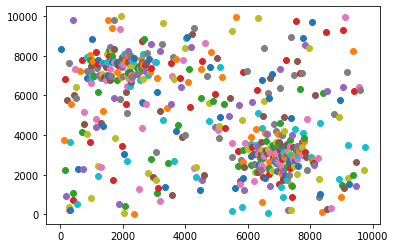

In [4]:
plot_2d(ue) # plot user locations

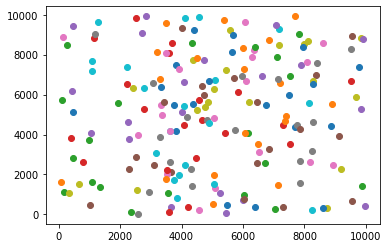

In [5]:
plot_2d(S) # plot possible BS locations

## BS placement optimisation algorithm (question 3)

Metropolis-Hastings Simulated Annealing optimisation algorithm is implemented as a Python class in anneal.py. Here, we initialise the class with a set of pregiven and computed parameters.

In [23]:
# Constants

B_max = 30 # Number of deployed BSs
R_ue = 1 # Individual UE revenue
C_bs = 5 # BS operational cos

# Optimisation parameters from the exercise description
opt_params = { 'B_max' :               B_max, # maximum amount of deployed BSs
               'R_ue' :                 R_ue, # revenue per served UE
               'C_bs' :                 C_bs, # operating cost of a BS
               'include_emf_exposure' :    0, # include emf exposure in optimisation, 0=False, 1=True
             }

# UE / BS parameters from ex. desc. and link budget
ue_bs_params = { 'R_cell' :  954, # cell radius
                 'h_bs' :   30.0, # bs height 
                 'h_ue' :    1.5, # ue height
                 'P_tx_bs' :  46, # bs transmission power
                 'G_ant_bs' : 19  # bs antenna gain
               }

Let's initialise an `Anneal` class object with the given parameters and run the algorithm:

In [57]:
SA = Anneal(ue, S, opt_params, ue_bs_params)
SA.anneal()

Starting annealing
---------------
BS sites, start = 1

Finished annealing
---------------
Best energy obtained:  -206.0
EMF over 6 V/m: 1 -- EMF over 0.6 V/m: 59
Highest EMF exposure [V/m]: 8.677111580618014
Users served: 351 -- bs sites: 29 -- energy: -206.0


## Performance figures (question 4)
Algorithm performance in terms of energy evolution of the accepted and best candidates can be visualised with the method `Anneal.plot_energy`. We see how energy varies heavily in the initial phase of the execution, as the algorithm is more likely to accept worse moves due to the higher energy. This allow it though explore the solution space to find potentially more efficient solutions. Random nature of elemental operation (add / remove / move) choices may be contributing factor in the higher variation of the converging graph. 

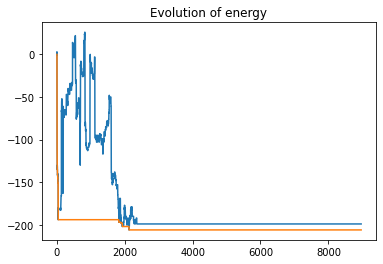

In [58]:
fig, ax1 = plt.subplots(1)
SA.plot_energy(ax1)

Let's continue by plotting a scatter plot with BS sites and their served customers. In the plot below, the black crosshairs indicate the BS sites, and the coloured dots the served UEs. Different colours indicate the cell boundaries of each BS.

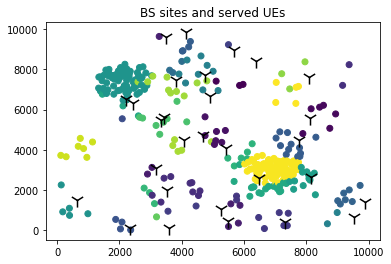

In [59]:
fig, ax2 = plt.subplots(1)
SA.plot_scatter_bs_ue(ax2)

## Possible improvements (question 5)
The algorithm is currently a very simplistic implementation and lacks consideration for many real world features, such as the more intricate effect of buildings and obstructing terrain. BS and UE locations are also placed on a simple flat plane instead of a varying geography with hills and troughs.

Different propagation models could also be used for the different BS sites depending on their location, as the 100 km² exhibits traits of both urban and rural settings with differing user densities.

## EMF figures for the base implementation (questions 6 & 7)
Let's consult the printout of the anneal method:
```
EMF over 6 V/m: 1 -- EMF over 0.6 V/m: 59
Highest EMF exposure [V/m]: 8.677111580618014
```
The results based on total exposure values computed with ```Anneal.candidate_emf_exposure```. The presented counts are taken from the best solution after the anneal process finishes.

## SA modifications and their EMF figures (question 8)
Base implementation leads into situations where EMF exposure of certain users exceeds the required values. This can be avoided to certain degree by penalising the energy function of the SA algorithm based on some EMF exposure figure. For my implementation, I chose the maximum individual exposure figure and cubed the value to reach the desired effect on the final results. Below is a demonstration of an execution where the EMF exposure was taken into account:

In [64]:
opt_params['include_emf_exposure'] = 1 # toggle the emf exposure optimisation

SA_EMF = Anneal(ue, S, opt_params, ue_bs_params)
SA_EMF.anneal()

Starting annealing
---------------
BS sites, start = 17

Finished annealing
---------------
Best energy obtained:  -0.4524453772114896
EMF over 6 V/m: 0 -- EMF over 0.6 V/m: 13
Highest EMF exposure [V/m]: 5.059913274026757
Users served: 270 -- bs sites: 28 -- energy: -0.4524453772114896


As we can see, the exposure figures are greatly reduced compared to the base implementation. Different BS site choices and evolution in energy are visualised below for the modified algorithm. It can be observed, that the energy spikes much higher compared to the base case. 

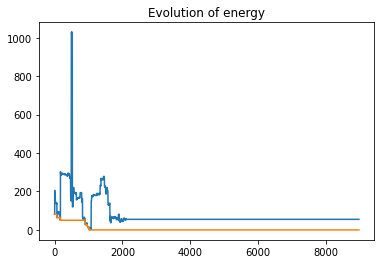

In [65]:
fig, ax3 = plt.subplots(1)
SA_EMF.plot_energy(ax3)

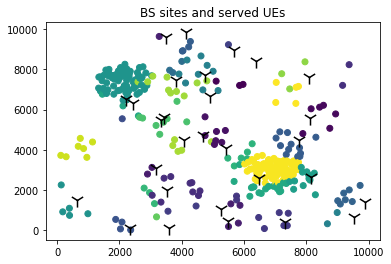

In [66]:
fig, ax4 = plt.subplots(1)
SA.plot_scatter_bs_ue(ax4)